# Classification of Oxford Pets

Обучим сеть для классификации исходного датасета [Oxford-IIIT Dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/). Для начала загружаем датасет:

In [ ]:
!wget https://mslearntensorflowlp.blob.core.windows.net/data/oxpets_images.tar.gz
!tar xfz oxpets_images.tar.gz
!rm oxpets_images.tar.gz

In [1]:
import matplotlib.pyplot as plt
import os
from PIL import Image
import numpy as np
import string

Получаем категории

In [ ]:
local_dir = os.getcwd()
detaset_dir = os.path.join(local_dir ,'images')
files = os.listdir(detaset_dir)

def get_categories(files):
    categories = set()
    for file in files:
        c = '_'.join(file.split("_")[:-1])
        categories.add(c)
    return categories
   
categories = get_categories(files)

Создаем директории и переносим туда изображения

In [ ]:
for categorie in categories:
    path = os.path.join(detaset_dir,categorie)
    os.mkdir(path)

In [ ]:
files = os.listdir(detaset_dir)
for c in categories:
    files.remove(c)

In [ ]:
import shutil
for file in files:
    c = '_'.join(file.split("_")[:-1])
    f = os.path.join(detaset_dir,file)
    path = os.path.join(detaset_dir,c)
    shutil.move(f,path)

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout

Считываем датасет

In [3]:
img_size = (224,224)
batch_size = 32
train_datagen = keras.preprocessing.image.ImageDataGenerator(validation_split=0.2)
train_dataset = train_datagen.flow_from_directory(batch_size=batch_size, directory='images', shuffle=True, target_size=img_size, subset="training",  class_mode='categorical')
validation_dataset = train_datagen.flow_from_directory(batch_size=batch_size,directory='images',shuffle=True,target_size=img_size, subset="validation",class_mode='categorical')

Found 5913 images belonging to 37 classes.
Found 1477 images belonging to 37 classes.


Создаем модель на основе VGG19

In [4]:
vgg = keras.applications.vgg19.VGG19(weights = 'imagenet', include_top = False,input_shape=(224,224,3))
for i in vgg.layers:
    i.trainable = False

model = keras.models.Sequential()
model.add(tf.keras.layers.Lambda(tf.keras.applications.vgg19.preprocess_input)) 
model.add(vgg)
model.add(Flatten())
model.add(Dense(37,activation='softmax'))
model.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['accuracy'])

In [5]:
hist = model.fit(train_dataset,epochs=5,validation_data=validation_dataset)

Epoch 1/5
185/185 [==============================] - 444s 2s/step - loss: 20.6932 - accuracy: 0.6342 - val_loss: 15.0728 - val_accuracy: 0.7299
Epoch 2/5
185/185 [==============================] - 439s 2s/step - loss: 4.5638 - accuracy: 0.8979 - val_loss: 18.5342 - val_accuracy: 0.7488
Epoch 3/5
185/185 [==============================] - 449s 2s/step - loss: 1.8827 - accuracy: 0.9515 - val_loss: 16.1320 - val_accuracy: 0.7732
Epoch 4/5
185/185 [==============================] - 438s 2s/step - loss: 1.2779 - accuracy: 0.9613 - val_loss: 18.2790 - val_accuracy: 0.7800
Epoch 5/5
185/185 [==============================] - 442s 2s/step - loss: 0.6319 - accuracy: 0.9811 - val_loss: 14.9576 - val_accuracy: 0.7942


Точность

In [6]:
print('Train accuracy: ' + str(hist.history['accuracy'][-1]))
print('Test accuracy: ' + str(hist.history['val_accuracy'][-1]))

Train accuracy: 0.981058657169342
Test accuracy: 0.7941774129867554


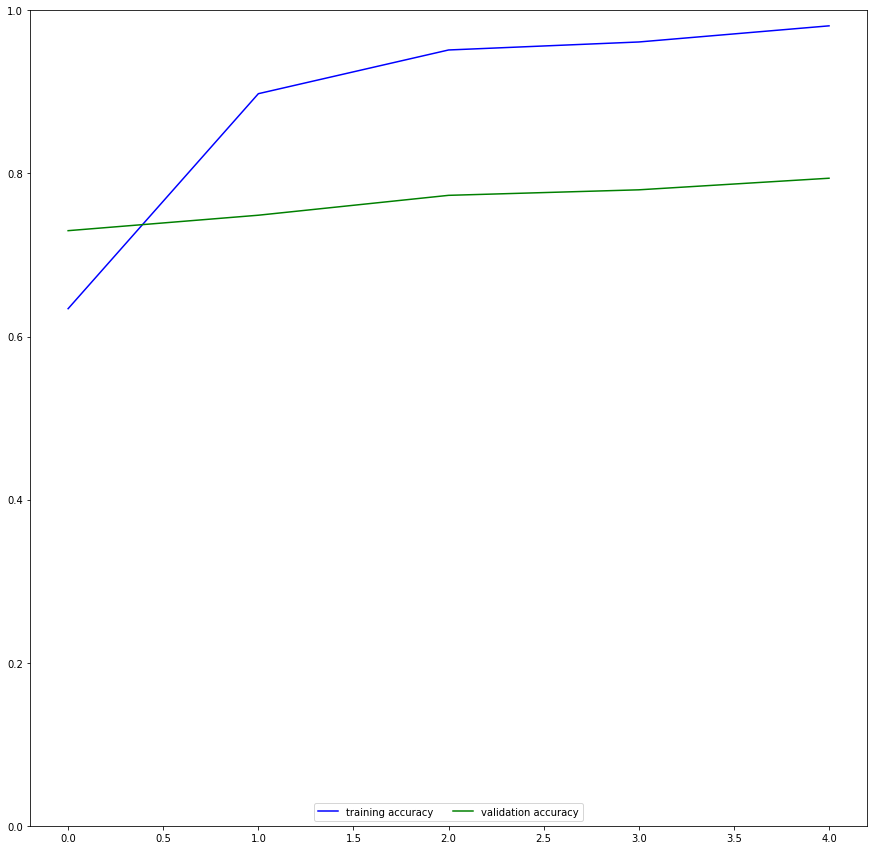

In [7]:
import matplotlib.pyplot as plt 
fig, ax = plt.subplots(figsize=(15, 15))
ax.plot(hist.history['accuracy'],'-b')
ax.plot(hist.history['val_accuracy'],'-g')
ax.legend(ax.lines, ['training accuracy', 'validation accuracy'],loc='lower center', ncol = 2)
plt.ylim([0, 1])
plt.show()

In [8]:
val = []
for i in range(len(validation_dataset)):
    for c in validation_dataset[i][0]:
        val.append(c)
val = np.array(val)
pred_vgg = model.predict(val)

47/47 [==============================] - 84s 2s/step


In [9]:
image_ans = []
for i in range(len(validation_dataset)):
    for c in validation_dataset[i][1]:
        image_ans.append(c)
image_ans = np.array(image_ans)

Сonfusion matrix

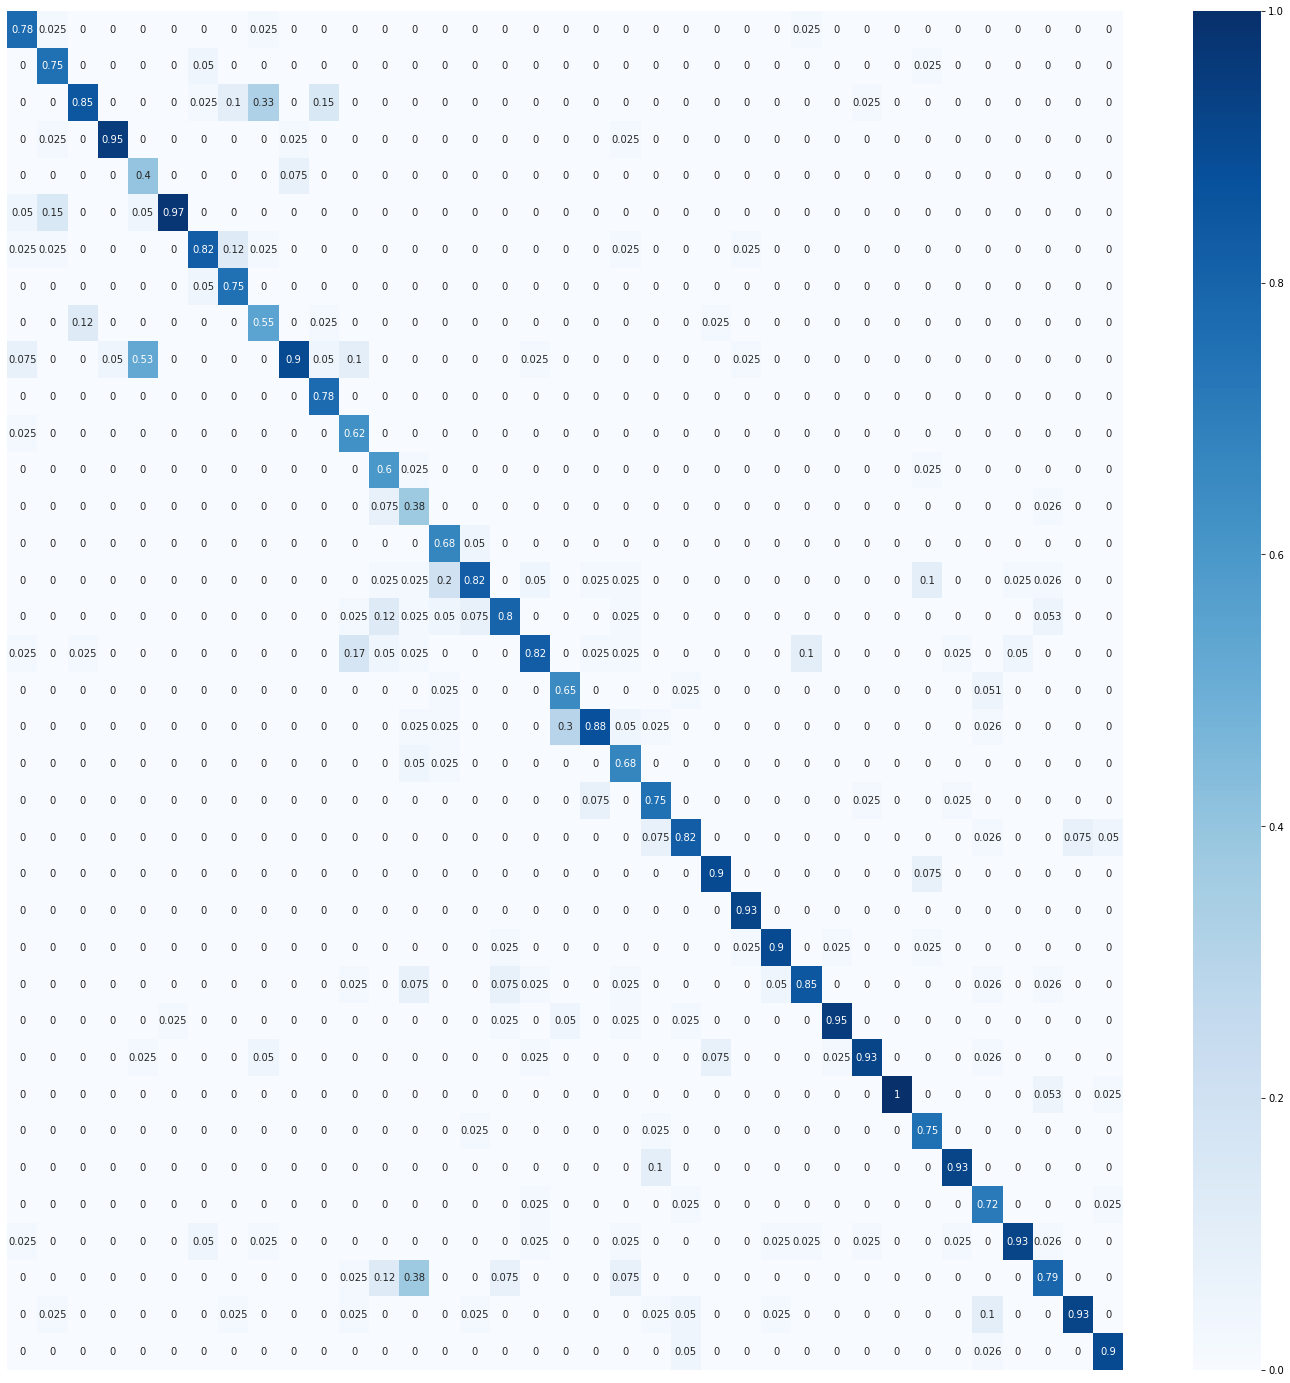

In [10]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
fig, ax = plt.subplots(figsize=(25, 25))
cf_matrix = confusion_matrix(pred_vgg.argmax(axis = 1), image_ans.argmax(axis = 1))
ax.set(xlabel=None, ylabel=None)
sns.heatmap(cf_matrix / cf_matrix.sum(axis=0), annot=True, cmap="Blues", ax=ax, yticklabels=False, xticklabels=False)
plt.show()

"Кошки против собак"

In [11]:
def Calc_Accuracy_cat_dog(y_pred,y):
    correct = 0
    total = 0
    for i in range(len(y_pred)):
        pr = (y_pred[i] <= 11)
        ans = (y[i] <= 11)
        if pr == ans :
            correct += 1
        total += 1
    return correct/total

In [12]:
print(f"Classification cat and dog accuracy vgg: {Calc_Accuracy_cat_dog(pred_vgg.argmax(axis = 1), image_ans.argmax(axis = 1))}")

Classification cat and dog accuracy vgg: 0.9783344617467841


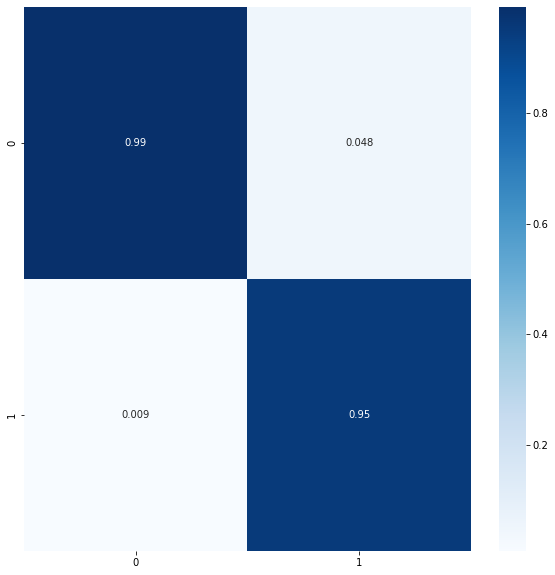

In [13]:
def to_cat_dog(pred):
    l = np.array([])
    for i in pred:
        l = np.append(l, [i <= 11])
    return l

cat_dog_pred_vgg = to_cat_dog(pred_vgg.argmax(axis = 1))
cat_dog_labels = to_cat_dog(image_ans.argmax(axis = 1))


fig, ax = plt.subplots(figsize=(10, 10))
cf_matrix_cat_dog_vgg = confusion_matrix(cat_dog_pred_vgg, cat_dog_labels)
cf_matrix_cat_dog_vgg = cf_matrix_cat_dog_vgg.astype('float') / cf_matrix_cat_dog_vgg.sum(axis=0)
sns.heatmap(cf_matrix_cat_dog_vgg, annot=True, cmap="Blues", ax=ax)
plt.show()

Top-5 accuracy

In [14]:
acc = np.diag(cf_matrix / cf_matrix.sum(axis=0))
top_ind = np.argsort(acc)[:-6:-1]
for i in top_ind:
    print(f'Accuracy {list(validation_dataset.class_indices.keys())[i]}: {acc[i]}')

Accuracy pug: 1.0
Accuracy Egyptian_Mau: 0.975
Accuracy Bombay: 0.95
Accuracy newfoundland: 0.95
Accuracy keeshond: 0.925


Создаем модель на основе ResNet

In [15]:
resnet = keras.applications.resnet.ResNet152(weights = 'imagenet', include_top = False,input_shape=(224,224,3))
for i in resnet.layers:
    i.trainable = False

model2 = keras.models.Sequential()
model2.add(tf.keras.layers.Lambda(tf.keras.applications.resnet.preprocess_input)) 
model2.add(resnet)
model2.add(Flatten())
model2.add(Dense(37,activation='softmax'))
model2.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['accuracy'])

In [16]:
hist2 = model2.fit(train_dataset,epochs=5,validation_data=validation_dataset)

Epoch 1/5
185/185 [==============================] - 504s 3s/step - loss: 9.0094 - accuracy: 0.7201 - val_loss: 6.0900 - val_accuracy: 0.8077
Epoch 2/5
185/185 [==============================] - 496s 3s/step - loss: 1.6929 - accuracy: 0.9256 - val_loss: 8.7928 - val_accuracy: 0.7949
Epoch 3/5
185/185 [==============================] - 497s 3s/step - loss: 0.8738 - accuracy: 0.9614 - val_loss: 6.0965 - val_accuracy: 0.8416
Epoch 4/5
185/185 [==============================] - 495s 3s/step - loss: 0.3104 - accuracy: 0.9806 - val_loss: 5.6880 - val_accuracy: 0.8558
Epoch 5/5
185/185 [==============================] - 492s 3s/step - loss: 0.1922 - accuracy: 0.9878 - val_loss: 5.2224 - val_accuracy: 0.8734


Точность

In [17]:
print('Train accuracy: ' + str(hist2.history['accuracy'][-1]))
print('Test accuracy: ' + str(hist2.history['val_accuracy'][-1]))

Train accuracy: 0.9878234267234802
Test accuracy: 0.8733919858932495


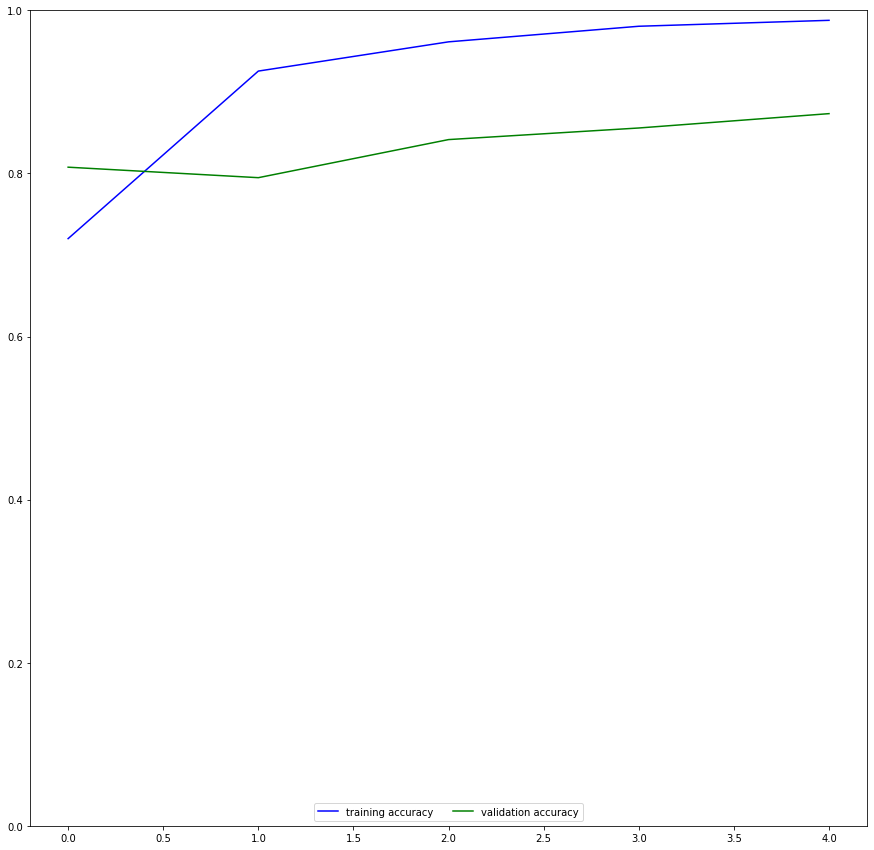

In [18]:
fig, ax = plt.subplots(figsize=(15, 15))
ax.plot(hist2.history['accuracy'],'-b')
ax.plot(hist2.history['val_accuracy'],'-g')
ax.legend(ax.lines, ['training accuracy', 'validation accuracy'],loc='lower center', ncol = 2)
plt.ylim([0, 1])
plt.show()

In [19]:
val2 = []
for i in range(len(validation_dataset)):
    for c in validation_dataset[i][0]:
        val2.append(c)
val2 = np.array(val2)
pred_res = model2.predict(val2)

47/47 [==============================] - 97s 2s/step


In [20]:
image_ans2 = []
for i in range(len(validation_dataset)):
    for c in validation_dataset[i][1]:
        image_ans2.append(c)
image_ans2 = np.array(image_ans2)

Сonfusion matrix

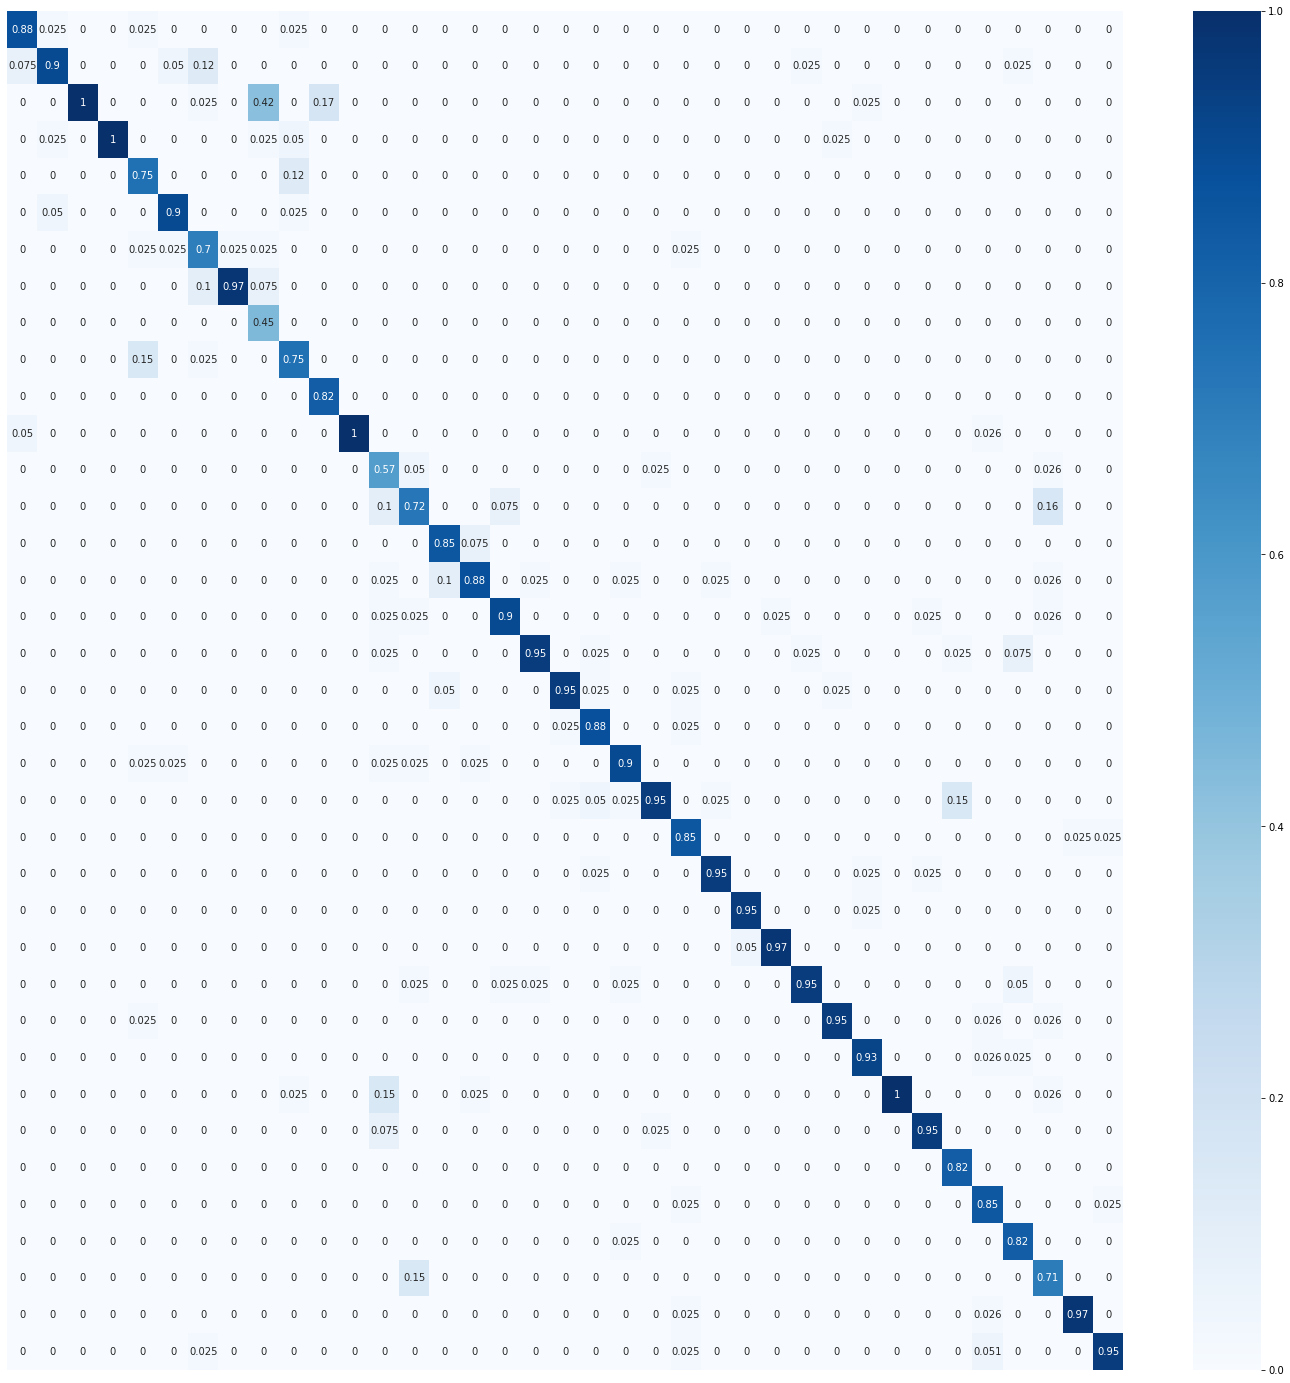

In [21]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
fig, ax = plt.subplots(figsize=(25, 25))
cf_matrix2 = confusion_matrix(pred_res.argmax(axis = 1), image_ans2.argmax(axis = 1))
ax.set(xlabel=None, ylabel=None)
sns.heatmap(cf_matrix2 / cf_matrix2.sum(axis=0), annot=True, cmap="Blues", ax=ax, yticklabels=False, xticklabels=False)
plt.show()

In [22]:
print(f"Classification cat and dog accuracy vgg: {Calc_Accuracy_cat_dog(pred_res.argmax(axis = 1), image_ans2.argmax(axis = 1))}")

Classification cat and dog accuracy vgg: 0.992552471225457


"Кошки против собак"

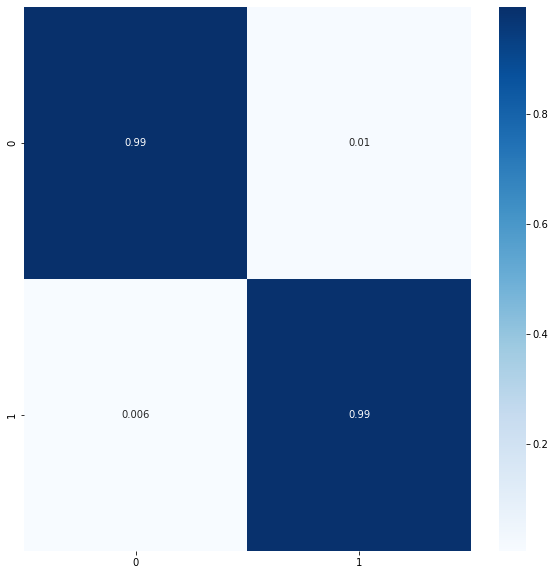

In [23]:
cat_dog_pred_res = to_cat_dog(pred_res.argmax(axis = 1))
cat_dog_labels2 = to_cat_dog(image_ans2.argmax(axis = 1))


fig, ax = plt.subplots(figsize=(10, 10))
cf_matrix_cat_dog_res = confusion_matrix(cat_dog_pred_res, cat_dog_labels2)
cf_matrix_cat_dog_res = cf_matrix_cat_dog_res.astype('float') / cf_matrix_cat_dog_res.sum(axis=0)
sns.heatmap(cf_matrix_cat_dog_res, annot=True, cmap="Blues", ax=ax)
plt.show()

Top-5 accuracy

In [24]:
acc = np.diag(cf_matrix2 / cf_matrix2.sum(axis=0))
top_ind2 = np.argsort(acc)[:-6:-1]
for i in top_ind2:
    print(f'Accuracy {list(validation_dataset.class_indices.keys())[i]}: {acc[i]}')

Accuracy Birman: 1.0
Accuracy Bombay: 1.0
Accuracy Sphynx: 1.0
Accuracy pug: 1.0
Accuracy Persian: 0.975
